Prior to running this script, generate anomalies in the dataset IF this dataset will be the "noisy" dataset. Otherwise this script should be run after the original dataset is cleaned (in our case duplicates were removed). Also, there is a separate notebook that uses this same script for the non noisy dataset. This script is specifically for normalizing the noisy dataset.

1. Imports

In [1]:
from replica_processor import *

Welcome to JupyROOT 6.24/06


2. Load data to construct normalization features

In [2]:
df = pd.read_csv('anomalous_dfs2.csv', dtype={'x':'int8','y':'int8','ftag_id':'int8','occ':'float32','hist_type':'int8','hist_id':'int16'})
df

,paths,x,y,occ,ftag_id,hist_type,hist_id,quality
0,run_363664/CaloMonitoring/ClusterMon/CaloCalTo...,0,0,3872943.0,0,0,0,1
1,run_363664/CaloMonitoring/ClusterMon/CaloCalTo...,0,1,4551316.0,0,0,0,1
2,run_363664/CaloMonitoring/ClusterMon/CaloCalTo...,0,2,0.0,0,0,0,0
3,run_363664/CaloMonitoring/ClusterMon/CaloCalTo...,0,3,3610718.0,0,0,0,1
4,run_363664/CaloMonitoring/ClusterMon/CaloCalTo...,0,4,0.0,0,0,0,0
...,...,...,...,...,...,...,...,...
41235475,run_360402/CaloMonitoring/ClusterMon/LArCluste...,98,60,0.0,84,17,233,0
41235476,run_360402/CaloMonitoring/ClusterMon/LArCluste...,98,61,0.0,84,17,233,0
41235477,run_360402/CaloMonitoring/ClusterMon/LArCluste...,98,62,0.0,84,17,233,0
41235478,run_360402/CaloMonitoring/ClusterMon/LArCluste...,98,63,78.0,84,17,233,1


3. Initialize normalization features in dataframe

In [3]:
df['occ_0to1'] = [0]*df.shape[0]
df['occ_zscore'] = [0]*df.shape[0]
df['occ_robust'] = [0]*df.shape[0]

4. Turn off unnecessary warning option

In [4]:
pd.options.mode.chained_assignment = None  # default='warn'

5. Normalize occupancy by histogram
- minmax
- zscore
- robust

In [5]:
# Slow process because the pointwise calculation of minmax goes through a for loop

# In the event of rerunning this script, if output_df is already in memory it will cause issues, remove it
try:
    del output_df
except:
    pass

# Loop through ftags in df
for idf,ftid in enumerate(df['ftag_id'].unique()):
    
    # Progress update for current ftag processing..
    progress_bar(idf,df['ftag_id'].unique())
    
    # Set the subset of df whose ftag_id is ftid to tmp
    mask1 = df['ftag_id'] == ftid
    tmp = df.loc[mask1,:]
    
    # Loop through hists for the current ftag
    for hid in tmp['hist_id'].unique():
        
        # Progress update of histogram currently in process..
        print(hid)\
        
        # Set the subset of tmp whose hist_id is hid to tmp2
        mask2 = tmp['hist_id'] == hid
        tmp2 = tmp.loc[mask2,:]

        # Calculate the normalization features and store them in their respective columns
        # MinMax scaling, not using standard deviation
        if tmp2['occ'].max() == tmp2['occ'].min():
            tmp2['occ_0to1'] = tmp2['occ']
            tmp2['occ_0to1'] = ( tmp2['occ']-tmp2['occ'].min() )/( tmp2['occ'].max()-tmp2['occ'].min() )
            
        # Zscore normalization
        tmp2['occ_zscore'] = ( tmp['occ']-tmp['occ'].mean() ) / tmp['occ'].std()
        
        # Robust nor\alization
        q75,q25 = np.percentile(tmp2['occ'],[75,25])
        iqr = q75-q25
        tmp2['occ_robust'] = ( tmp2['occ']-tmp2['occ'].median() )/iqr

        # Record the subset of datapoints whose normalized occupancies have been calculated into the main dataframe 
        df.loc[tmp2.index,:] = tmp2

Processing file 83 of 83 files... 100.0% Complete
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233


6. Some Exploratory Analysis test to make sure it worked:

In [6]:
# Looks good so far
df

,paths,x,y,occ,ftag_id,hist_type,hist_id,quality,occ_0to1,occ_zscore,occ_robust
0,run_363664/CaloMonitoring/ClusterMon/CaloCalTo...,0,0,3872943.0,0,0,0,1,0.084320,3.641077,1.564232
1,run_363664/CaloMonitoring/ClusterMon/CaloCalTo...,0,1,4551316.0,0,0,0,1,0.099089,4.307510,1.903885
2,run_363664/CaloMonitoring/ClusterMon/CaloCalTo...,0,2,0.0,0,0,0,0,0.000000,-0.163700,-0.374900
3,run_363664/CaloMonitoring/ClusterMon/CaloCalTo...,0,3,3610718.0,0,0,0,1,0.078611,3.383467,1.432940
4,run_363664/CaloMonitoring/ClusterMon/CaloCalTo...,0,4,0.0,0,0,0,0,0.000000,-0.163700,-0.374900
...,...,...,...,...,...,...,...,...,...,...,...
41235475,run_360402/CaloMonitoring/ClusterMon/LArCluste...,98,60,0.0,84,17,233,0,0.000000,-0.090706,-0.170740
41235476,run_360402/CaloMonitoring/ClusterMon/LArCluste...,98,61,0.0,84,17,233,0,0.000000,-0.090706,-0.170740
41235477,run_360402/CaloMonitoring/ClusterMon/LArCluste...,98,62,0.0,84,17,233,0,0.000000,-0.090706,-0.170740
41235478,run_360402/CaloMonitoring/ClusterMon/LArCluste...,98,63,78.0,84,17,233,1,0.006434,-0.090692,0.036157


<IPython.core.display.Javascript object>

,paths,x,y,occ,ftag_id,hist_type,hist_id,quality,occ_0to1,occ_zscore,occ_robust
0,run_363664/CaloMonitoring/ClusterMon/CaloCalTo...,0,0,3872943.0,0,0,0,1,0.084320,3.641077,1.564232
1,run_363664/CaloMonitoring/ClusterMon/CaloCalTo...,0,1,4551316.0,0,0,0,1,0.099089,4.307510,1.903885
2,run_363664/CaloMonitoring/ClusterMon/CaloCalTo...,0,2,0.0,0,0,0,0,0.000000,-0.163700,-0.374900
3,run_363664/CaloMonitoring/ClusterMon/CaloCalTo...,0,3,3610718.0,0,0,0,1,0.078611,3.383467,1.432940
4,run_363664/CaloMonitoring/ClusterMon/CaloCalTo...,0,4,0.0,0,0,0,0,0.000000,-0.163700,-0.374900


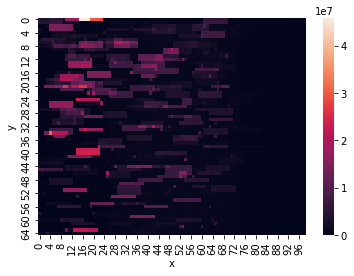

In [7]:
# Get a histogram subset to view some specifics
test = df[df['ftag_id']==0]
test = test[test['hist_id']==0]
sns.heatmap( test.pivot_table(index='y',columns='x',values='occ') )
test.head()

In [8]:
test.describe()

,x,y,occ,ftag_id,hist_type,hist_id,quality,occ_0to1,occ_zscore,occ_robust
count,6435.000000,6435.000000,6435.00,6435.0,6435.0,6435.0,6435.000000,6435.000000,6435.000000,6435.000000
mean,49.000000,32.000000,2299795.75,0.0,0.0,0.0,0.462937,0.050070,2.095618,0.776578
std,28.579601,18.763121,4196113.50,0.0,0.0,0.0,0.498663,0.091356,4.122260,2.100939
min,0.000000,0.000000,0.00,0.0,0.0,0.0,0.000000,0.000000,-0.163700,-0.374900
25%,24.000000,16.000000,73419.50,0.0,0.0,0.0,0.000000,0.001598,-0.091573,-0.338140
50%,49.000000,32.000000,748771.00,0.0,0.0,0.0,0.000000,0.016302,0.571892,0.000000
75%,74.000000,48.000000,2070675.50,0.0,0.0,0.0,1.000000,0.045082,1.870530,0.661860
max,98.000000,64.000000,45931620.00,0.0,0.0,0.0,1.000000,1.000000,44.959503,22.622461


In [14]:
test = test[test['x']==48]
test

,paths,x,y,occ,ftag_id,hist_type,hist_id,quality,occ_0to1,occ_zscore,occ_robust
3120,run_363664/CaloMonitoring/ClusterMon/CaloCalTo...,48,0,0.0,0,0,0,0,0.000000,-0.149639,-0.241575
3121,run_363664/CaloMonitoring/ClusterMon/CaloCalTo...,48,1,789285.0,0,0,0,0,0.791145,1.137831,0.844842
3122,run_363664/CaloMonitoring/ClusterMon/CaloCalTo...,48,2,830367.0,0,0,0,0,0.832324,1.204843,0.901390
3123,run_363664/CaloMonitoring/ClusterMon/CaloCalTo...,48,3,842654.0,0,0,0,0,0.844640,1.224886,0.918302
3124,run_363664/CaloMonitoring/ClusterMon/CaloCalTo...,48,4,839267.0,0,0,0,0,0.841245,1.219361,0.913640
...,...,...,...,...,...,...,...,...,...,...,...
3180,run_363664/CaloMonitoring/ClusterMon/CaloCalTo...,48,60,836679.0,0,0,0,0,0.838651,1.215139,0.910078
3181,run_363664/CaloMonitoring/ClusterMon/CaloCalTo...,48,61,808268.0,0,0,0,0,0.810173,1.168796,0.870972
3182,run_363664/CaloMonitoring/ClusterMon/CaloCalTo...,48,62,788494.0,0,0,0,0,0.790352,1.136541,0.843753
3183,run_363664/CaloMonitoring/ClusterMon/CaloCalTo...,48,63,831477.0,0,0,0,0,0.833436,1.206654,0.902918


<IPython.core.display.Javascript object>

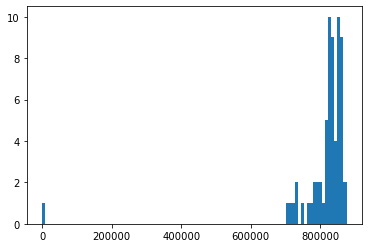

In [15]:
plt.hist(test['occ'],bins=100);

<IPython.core.display.Javascript object>

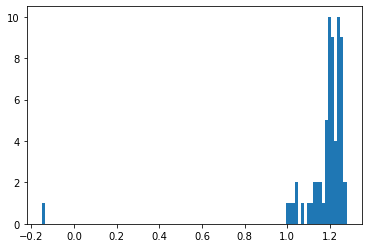

In [16]:
plt.hist(test['occ_zscore'], bins=100);

<IPython.core.display.Javascript object>

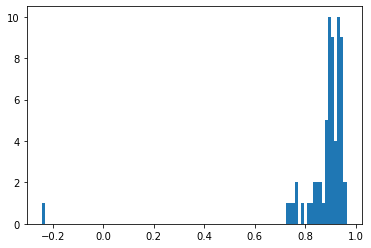

In [17]:
plt.hist(test['occ_robust'], bins=100);

<IPython.core.display.Javascript object>

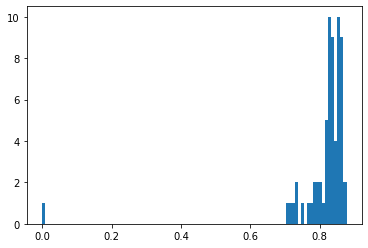

In [18]:
plt.hist(test['occ_0to1'], bins=100);

In [19]:
# What kind of values does the zscore feature have
test['occ_zscore'].value_counts()

1.241491    1
1.204791    1
1.237051    1
1.215818    1
1.255516    1
           ..
1.106409    1
1.245236    1
1.240468    1
1.039037    1
1.236511    1
Name: occ_zscore, Length: 65, dtype: int64

In [20]:
# What kind of values does the robust feature have?
test['occ_robust'].value_counts()

0.891620    1
0.918302    1
0.943793    1
0.912011    1
0.901346    1
           ..
0.843753    1
0.818328    1
0.943259    1
0.935475    1
0.949364    1
Name: occ_robust, Length: 65, dtype: int64

In [21]:
# What kind of values does the 0to1 feature have?
test['occ_0to1'].value_counts()

0.000000    1
0.849129    1
0.730436    1
0.771837    1
0.875889    1
           ..
0.837056    1
0.819296    1
0.825209    1
0.857636    1
0.857145    1
Name: occ_0to1, Length: 65, dtype: int64

In [22]:
# A deeper look at the values in 0to1 since the vast majority are 0's
test[test['occ_0to1']!=0]

,paths,x,y,occ,ftag_id,hist_type,hist_id,quality,occ_0to1,occ_zscore,occ_robust
3121,run_363664/CaloMonitoring/ClusterMon/CaloCalTo...,48,1,789285.0,0,0,0,0,0.791145,1.137831,0.844842
3122,run_363664/CaloMonitoring/ClusterMon/CaloCalTo...,48,2,830367.0,0,0,0,0,0.832324,1.204843,0.901390
3123,run_363664/CaloMonitoring/ClusterMon/CaloCalTo...,48,3,842654.0,0,0,0,0,0.844640,1.224886,0.918302
3124,run_363664/CaloMonitoring/ClusterMon/CaloCalTo...,48,4,839267.0,0,0,0,0,0.841245,1.219361,0.913640
3125,run_363664/CaloMonitoring/ClusterMon/CaloCalTo...,48,5,849781.0,0,0,0,0,0.851784,1.236511,0.928112
...,...,...,...,...,...,...,...,...,...,...,...
3180,run_363664/CaloMonitoring/ClusterMon/CaloCalTo...,48,60,836679.0,0,0,0,0,0.838651,1.215139,0.910078
3181,run_363664/CaloMonitoring/ClusterMon/CaloCalTo...,48,61,808268.0,0,0,0,0,0.810173,1.168796,0.870972
3182,run_363664/CaloMonitoring/ClusterMon/CaloCalTo...,48,62,788494.0,0,0,0,0,0.790352,1.136541,0.843753
3183,run_363664/CaloMonitoring/ClusterMon/CaloCalTo...,48,63,831477.0,0,0,0,0,0.833436,1.206654,0.902918


7. Save the updated dataframe now containing both anomalous data and data normalized on occupancy on a histogram per histogram basis
- For EDA, consider looking at the distributions of occupancies of different histograms and different norm features

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41235480 entries, 0 to 41235479
Data columns (total 11 columns):
 #   Column      Dtype  
---  ------      -----  
 0   paths       object 
 1   x           int8   
 2   y           int8   
 3   occ         float32
 4   ftag_id     int8   
 5   hist_type   int8   
 6   hist_id     int16  
 7   quality     int64  
 8   occ_0to1    float64
 9   occ_zscore  float64
 10  occ_robust  float64
dtypes: float32(1), float64(3), int16(1), int64(1), int8(4), object(1)
memory usage: 1.9+ GB


In [26]:
df['occ_0to1'] = df['occ_0to1'].astype('float32')
df['occ_zscore'] = df['occ_zscore'].astype('float32')
df['occ_robust'] = df['occ_robust'].astype('float32')
df['quality'] = df['quality'].astype('int8')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41235480 entries, 0 to 41235479
Data columns (total 11 columns):
 #   Column      Dtype  
---  ------      -----  
 0   paths       object 
 1   x           int8   
 2   y           int8   
 3   occ         float32
 4   ftag_id     int8   
 5   hist_type   int8   
 6   hist_id     int16  
 7   quality     int8   
 8   occ_0to1    float32
 9   occ_zscore  float32
 10  occ_robust  float32
dtypes: float32(4), int16(1), int8(5), object(1)
memory usage: 1.2+ GB


In [9]:
# Save the results
df.to_csv('normed_anoms2.csv',index=False)

In [ ]:
# To load, use the following
df = pd.read_csv('normed_anoms2.csv', dtype={'x':'int8','y':'int8','ftag_id':'int8','occ':'float32','hist_type':'int8','hist_id':'int16','quality':'int8','occ_0to1':'float32','occ_zscore':'float32','occ_robust':'float32'})
df

This anomaly dataset can now be moved to the splitting script